# Machine Learning -classification <a class="tocSkip">

## Library 

In [40]:
# Load general utilities
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import numpy as np
import pickle
import time
import seaborn as sns
import os
from IPython import get_ipython
ipython = get_ipython()
# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Load sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.calibration import calibration_curve

# Load classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

## Import data

In [6]:
# read data
start = time.time()
path = '/Users/cyuancheng/Documents/course/Springboard/Capstone1/data/'
df = pd.read_csv(path+'LC_ML_prep.csv', low_memory=False, index_col=0, \
                 parse_dates=['issue_d', 'earliest_cr_line', 'last_pymnt_d'] )
end = time.time()
print('It takes  ' + str(round((end-start)/60, 1)) +' min to read the data')

It takes  0.2 min to read the data


In [9]:
df.head()

,home_ownership,verification_status,purpose,addr_state,pub_rec,term_num,grade_num,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal,log_delinq_2yrs,emp_length_num,Log_Annual_ROI,issue_d,earliest_cr_line,last_pymnt_d,target
1,MORTGAGE,Not Verified,debt_consolidation,TX,0.0,36,7,29.996509,7.62,55.7,12000.0,12000.0,373.94,17.0,709.0,13397.539998,4.984527,1.100715,4.122150,-inf,3.0,-1.346243,2013-12-01,2003-09-01,2016-06-01,0
2,OWN,Verified,debt_consolidation,MI,0.0,36,6,30.982156,10.99,61.2,27050.0,27050.0,885.46,14.0,734.0,31752.530000,4.740363,1.359266,4.563932,-inf,10.0,-1.193486,2013-12-01,1986-10-01,2016-07-01,0
3,RENT,Not Verified,debt_consolidation,NC,0.0,36,6,27.992361,10.99,24.0,12000.0,12000.0,392.81,15.0,724.0,13988.609996,4.778151,0.664642,3.853516,-inf,4.0,-1.167860,2013-12-01,2009-12-01,2016-04-01,0
5,MORTGAGE,Not Verified,debt_consolidation,CT,0.0,36,7,37.027454,6.62,21.6,12000.0,12000.0,368.45,12.0,764.0,13263.954639,5.021189,1.147676,4.119520,-inf,10.0,-1.481653,2013-12-01,1994-03-01,2017-01-01,0
6,RENT,Not Verified,debt_consolidation,NC,1.0,36,6,37.027454,12.85,81.9,14000.0,14000.0,470.71,6.0,674.0,16945.318783,4.944483,1.000868,3.566555,0.0,4.0,-1.194953,2013-12-01,1988-06-01,2017-01-01,0


In [10]:
df.shape

(1040120, 26)

## Feature Engineering

#### 1. datetime
Converting the datetime columns into integer number of year and month 

In [86]:
col_dt = df.select_dtypes('datetime64').columns
print(col_dt)
print('number of datetime features =', len(col_dt))

Index(['issue_d', 'earliest_cr_line', 'last_pymnt_d'], dtype='object')
number of datetime features = 3


In [92]:
df['issue_y']=pd.to_datetime(df['issue_d']).apply(lambda x: int(x.strftime('%Y')))
df['issue_m']=pd.to_datetime(df['issue_d']).apply(lambda x: int(x.strftime('%m')))
df['earliest_cr_line_y']=pd.to_datetime(df['earliest_cr_line']).apply(lambda x: int(x.strftime('%Y')))
df['earliest_cr_line_m']=pd.to_datetime(df['earliest_cr_line']).apply(lambda x: int(x.strftime('%m')))
df['last_pymnt_y']=pd.to_datetime(df['last_pymnt_d']).apply(lambda x: int(x.strftime('%Y')))
df['last_pymnt_m']=pd.to_datetime(df['last_pymnt_d']).apply(lambda x: int(x.strftime('%m')))

In [97]:
# drop datetime columns
df.drop(col_dt, axis=1, inplace=True)

#### 2. Categorical variable

In [99]:
col_cat = df.select_dtypes('object').columns
print(col_cat)
print('number of categorical features =', len(col_cat))

Index(['home_ownership', 'verification_status', 'purpose', 'addr_state'], dtype='object')
number of categorical features = 4


In [100]:
#one-hot encoding
df_cat = pd.get_dummies(df[col_cat],dummy_na=True)
df_cat.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_nan,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,addr_state_AK,...,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan
1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 3. Numerical variable

In [101]:
col_num = df.select_dtypes('float').columns 
print(col_num)
print('number of numerical feature =', len(col_num))

Index(['pub_rec', 'loan_period', 'int_rate', 'revol_util', 'loan_amnt',
       'funded_amnt', 'installment', 'open_acc', 'fico', 'total_pymnt',
       'log_annual_inc', 'log_dti', 'log_revol_bal', 'log_delinq_2yrs',
       'emp_length_num', 'Log_Annual_ROI'],
      dtype='object')
number of numerical feature = 16


In [102]:
col_int = df.select_dtypes('int64').columns 
print(col_int)

Index(['term_num', 'grade_num', 'target', 'issue_y', 'issue_m',
       'earliest_cr_line_y', 'earliest_cr_line_m', 'last_pymnt_y',
       'last_pymnt_m'],
      dtype='object')


In [103]:
df_num = pd.concat((df[col_num], df[col_int]),axis=1)
df_num.drop(['log_delinq_2yrs'], axis=1, inplace=True)
df_num.head()

,pub_rec,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal,emp_length_num,Log_Annual_ROI,term_num,grade_num,target,issue_y,issue_m,earliest_cr_line_y,earliest_cr_line_m,last_pymnt_y,last_pymnt_m
1,0.0,29.996509,7.62,55.7,12000.0,12000.0,373.94,17.0,709.0,13397.539998,4.984527,1.100715,4.122150,3.0,-1.346243,36,7,0,2013,12,2003,9,2016,6
2,0.0,30.982156,10.99,61.2,27050.0,27050.0,885.46,14.0,734.0,31752.530000,4.740363,1.359266,4.563932,10.0,-1.193486,36,6,0,2013,12,1986,10,2016,7
3,0.0,27.992361,10.99,24.0,12000.0,12000.0,392.81,15.0,724.0,13988.609996,4.778151,0.664642,3.853516,4.0,-1.167860,36,6,0,2013,12,2009,12,2016,4
5,0.0,37.027454,6.62,21.6,12000.0,12000.0,368.45,12.0,764.0,13263.954639,5.021189,1.147676,4.119520,10.0,-1.481653,36,7,0,2013,12,1994,3,2017,1
6,1.0,37.027454,12.85,81.9,14000.0,14000.0,470.71,6.0,674.0,16945.318783,4.944483,1.000868,3.566555,4.0,-1.194953,36,6,0,2013,12,1988,6,2017,1


In [104]:
df_num.shape

(1040120, 24)

### Feature Selection

#### 1. Eliminate correlated features 

- From the Pearson correlation heatmap, we found that for prediction on default as target, the annual ROI is the most predicative of all features, followed by grade, and interest rate; while total payment has negative impact.
- To avoid overfitting, we eliminated the features that are highly correlated with each other, and only keep the following features.  (multicollinearity)
 

#### - Eliminate feature that is uncorrelated with target

In [113]:
#Correlation with output variable
cor = df_num.corr()
cor_target = abs(cor["target"])

# only keep correlation >0.01 with target
#relevant_features = cor_target
relevant_features = cor_target[cor_target>0.01] 
relevant_features.sort_values(ascending=False)

target            1.000000
Log_Annual_ROI    0.286013
grade_num         0.152650
total_pymnt       0.146203
int_rate          0.145206
term_num          0.121476
fico              0.085009
loan_amnt         0.054518
funded_amnt       0.054514
log_dti           0.052761
revol_util        0.042874
log_annual_inc    0.040290
issue_y           0.034426
last_pymnt_y      0.032592
installment       0.031009
open_acc          0.021982
pub_rec           0.021259
Name: target, dtype: float64

In [114]:
# list relevant features
list_feature = relevant_features.to_frame().index.to_list()
print(list_feature)

['pub_rec', 'int_rate', 'revol_util', 'loan_amnt', 'funded_amnt', 'installment', 'open_acc', 'fico', 'total_pymnt', 'log_annual_inc', 'log_dti', 'Log_Annual_ROI', 'term_num', 'grade_num', 'target', 'issue_y', 'last_pymnt_y']


#### - Eliminate feature that is higly correlated with each other (multicollinearity)

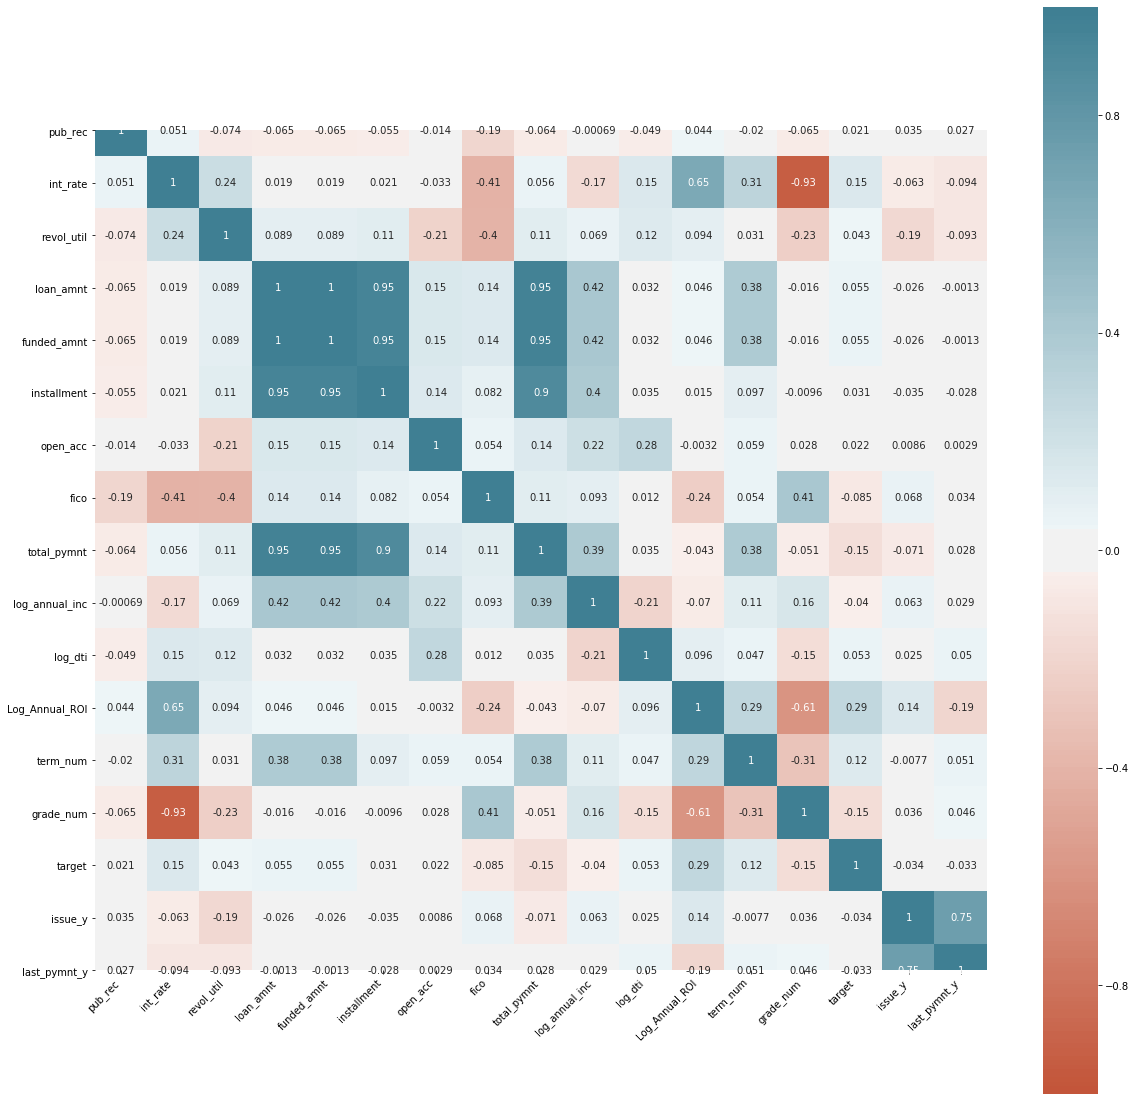

In [110]:
# heatmap

plt.figure(figsize=(20,20))

ax = sns.heatmap(
    df_num[list_feature].corr(), 
    vmin=-1, vmax=1, center=0,annot = True,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

remove funded_amnt, installment, total_paymnt

In [115]:
list_feature.remove('funded_amnt')
list_feature.remove('installment')
list_feature.remove('total_pymnt')
list_feature.remove('grade_num')
list_feature.remove('last_pymnt_y')

In [116]:
list_feature

['pub_rec',
 'int_rate',
 'revol_util',
 'loan_amnt',
 'open_acc',
 'fico',
 'log_annual_inc',
 'log_dti',
 'Log_Annual_ROI',
 'term_num',
 'target',
 'issue_y']

In [117]:
# combine numerical variable and categorical variable
df_feature = pd.concat((df[list_feature], df_cat),axis=1)
df_feature.drop(['target'], axis=1, inplace=True) 
df_feature.head()

,pub_rec,int_rate,revol_util,loan_amnt,open_acc,fico,log_annual_inc,log_dti,Log_Annual_ROI,term_num,issue_y,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_nan,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,...,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan
1,0.0,7.62,55.7,12000.0,17.0,709.0,4.984527,1.100715,-1.346243,36,2013,0,1,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0.0,10.99,61.2,27050.0,14.0,734.0,4.740363,1.359266,-1.193486,36,2013,0,0,0,1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,10.99,24.0,12000.0,15.0,724.0,4.778151,0.664642,-1.167860,36,2013,0,0,0,0,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.0,6.62,21.6,12000.0,12.0,764.0,5.021189,1.147676,-1.481653,36,2013,0,1,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1.0,12.85,81.9,14000.0,6.0,674.0,4.944483,1.000868,-1.194953,36,2013,0,0,0,0,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [119]:
X=df_feature 
y=df['target']

### Train test split

Always split into test and train sets BEFORE trying oversampling techniques!

In [120]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [121]:
# Standarization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Oversampling by SMOTE
Oversampling the training set using Synthetic Minority Oversampling Technique ([SMOTE](https://jair.org/index.php/jair/article/view/10302/24590))

In [82]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=33, ratio = 1.0)
x_train_os, y_train_os = sm.fit_sample(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


KeyboardInterrupt: 

### Train test split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_feature, y, test_size=0.3)

# standarization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
print(X_train.shape)
print(X_test.shape)

(728084, 85)
(312036, 85)


## Model
### Logistic Regression

In [43]:
logisticModel = LogisticRegression()#CV(cv=3,penalty='l2')
logisticModel.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
def metrics(y_test, y_pred):
    print('accuracy: ',accuracy_score(y_test,y_pred))
    target_names = ['Non-Defaulted Loan','Defaulted Loan']
    print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
    

In [ ]:
def auc_ruc(X_test, y_test, model=logisticModel):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1],
                                         pos_label=1)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', \
             label='AUC = %0.2f'% roc_auc_score(y_test,logisticModel.predict_proba(X_test)[:,1]))
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [44]:
y_pred = logisticModel.predict(X_test)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,logisticModel.predict_proba(X_test)[:,1]))

accuracy:  0.9232812880565063
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9227    0.9993    0.9595    283688
    Defaulted Loan     0.9601    0.1623    0.2776     28348

          accuracy                         0.9233    312036
         macro avg     0.9414    0.5808    0.6186    312036
      weighted avg     0.9261    0.9233    0.8975    312036

AUC:  0.7244266731397466


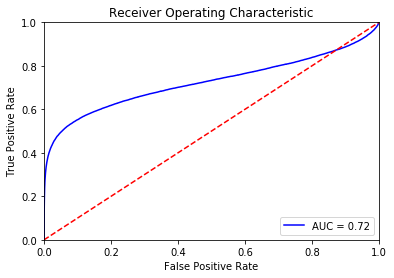

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, logisticModel.predict_proba(X_test)[:,1],
                                         pos_label=1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc_score(y_test,logisticModel.predict_proba(X_test)[:,1]))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Normality test
Check the normality by Shapiro-Wilk test and QQ plot.
#### Shapiro-Wilk Test

    -  Ho: Sample is Gaussian
    -  H1: Sample is not Gaussian


In [22]:
# Shapiro-Wilk Test

def Shapiro_Wilk(data):
    # seed the random number generator
    seed(1)
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [23]:
# postive return
Shapiro_Wilk(log_return_pos_rm)

Statistics=0.998, p=0.000
Sample does not look Gaussian (reject H0)


In [24]:
# negative return
Shapiro_Wilk(log_return_neg_rm)

Statistics=0.891, p=0.000
Sample does not look Gaussian (reject H0)


**Both log return for gain and loss are not normal distribution**

#### QQ plot

Text(0.5, 1.0, 'Return (loss)')

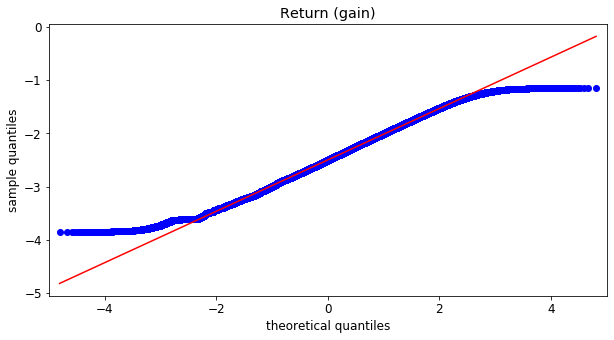

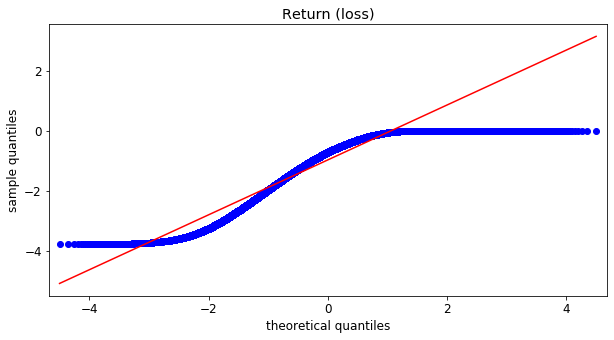

In [25]:
sm.qqplot(log_return_pos_rm, line='s')
plt.grid(False)
plt.rcParams.update({'font.size': 12})
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')
plt.title('Return (gain)')

sm.qqplot(log_return_neg_rm, line='s')
plt.grid(False)
plt.rcParams.update({'font.size': 12})
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')
plt.title('Return (loss)')

qq plot shows linear in the center region, but flat on the edge. It suggests the return is not normal distribution.

### Default vs return
It would be interesting to see how default related to return. We can explect that the investors whose loans are not default get postive return. But the question is can default loan has any postive return? 

In [26]:
# quick calculation for return in default and payoff loan. 
print('default & gain =', len(df.query('target == 1 & Annual_ROI >0'))/len(df.query('target == 1')))      
print('default & loss =', len(df.query('target == 1 & Annual_ROI <0'))/len(df.query('target == 1')))

print('payoff & gain =', len(df.query('target == 0 & Annual_ROI >0'))/len(df.query('target == 0')))
print('payoff & loss =', len(df.query('target == 0 & Annual_ROI <0'))/len(df.query('target == 0')))


default & gain = 0.08479159164291339
default & loss = 0.9152053565433937
payoff & gain = 0.9999812636119859
payoff & loss = 0.0


So indeed, all the good loan (no default) has postive return. But there are 8% of default loan has postive return.

In [34]:
df['grade_num']=df['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})

df_default_pos = df.query('target == 1 & Annual_ROI >0')#['return']
df_payoff_pos = df.query('target == 0 & Annual_ROI >0')#['return']

In [28]:
display(df_default_pos['Annual_ROI'].describe())
display(df_payoff_pos['Annual_ROI'].describe())

count    27784.000000
mean         0.042831
std          0.071668
min          0.000003
25%          0.016171
50%          0.033878
75%          0.056121
max          3.837749
Name: Annual_ROI, dtype: float64

count    1.334277e+06
mean     9.376749e-02
std      5.040895e-02
min      3.740324e-07
25%      5.914229e-02
50%      8.227393e-02
75%      1.158056e-01
max      1.049295e+00
Name: Annual_ROI, dtype: float64

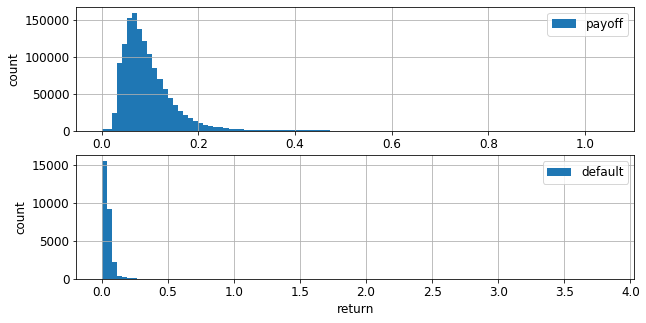

In [29]:
plt.subplot(211)
df_payoff_pos['Annual_ROI'].hist(bins=100, label='payoff')
plt.legend()
plt.ylabel('count')
plt.subplot(212)
df_default_pos['Annual_ROI'].hist(bins=100, label='default')
plt.ylabel('count')
plt.xlabel('return')
plt.legend()
plt.show()

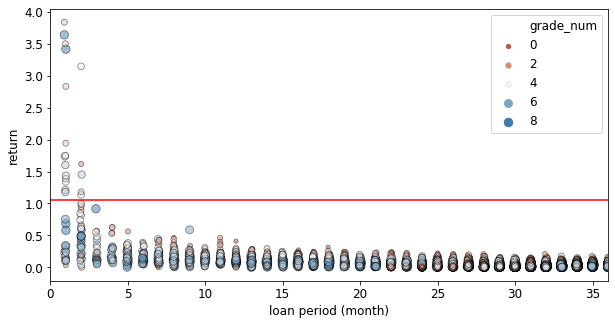

In [71]:
#plt.scatter(df_default_pos['loan_period'], df_default_pos['return_'])
#sns.palplot(sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True))
#seq_col_brew = sns.color_palette("Blues_r", 4)
#sns.set_palette(seq_col_brew)

#cmap = sns.cubehelix_palette(8, light=0.8, reverse=True,
#                             as_cmap=True)

cmap = sns.diverging_palette(20,240, n=9, as_cmap=True)
plt.figure(figsize=(10,5))
sns.scatterplot(x='loan_period', y='Annual_ROI', hue='grade_num', \
                edgecolor='black',size='grade_num',alpha=0.5, palette=cmap, data=df_default_pos)

plt.xlabel('loan period (month)')
plt.axhline(np.max(df[df['target']==0]['Annual_ROI']), color='r', linestyle='-')
plt.ylabel('return')
plt.xlim([0,36])
plt.show()



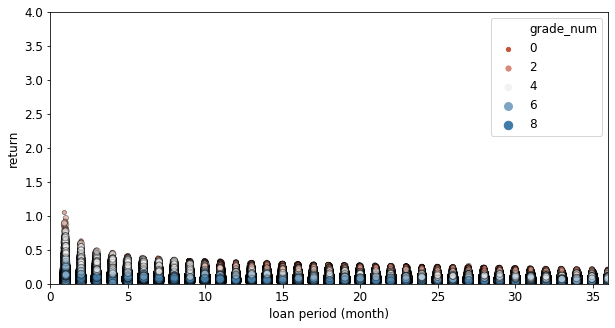

In [72]:
#sns.scatterplot(x='loan_period', y='return_', data=df_payoff_pos)


cmap = sns.diverging_palette(20,240, n=9, as_cmap=True)

plt.figure(figsize=(10,5))
sns.scatterplot(x='loan_period', y='Annual_ROI', hue='grade_num', \
                edgecolor='black',size='grade_num',alpha=0.5, palette=cmap, data=df_payoff_pos)

plt.xlabel('loan period (month)')
#plt.axhline(np.mean(df[df['target']==0]['Annual_ROI']), color='r', linestyle='-')
plt.ylabel('return')
plt.ylim([0,4])
plt.xlim([0,36])
plt.show()

In [74]:
# pull out high risk loan
df_risk = df[df['Annual_ROI']>1]

In [75]:
len(df_risk)

20

In [76]:
df_risk

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d,int_rate,revol_util,loan_status,home_ownership,sub_grade,debt_settlement_flag,grade,application_type,purpose,initial_list_status,hardship_flag,title,emp_length,pymnt_plan,verification_status,addr_state,term,loan_amnt,funded_amnt,funded_amnt_inv,int_rate.1,...,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_period,target,term_num,Annual_ROI,credit_period,region,fico,emp_length_num,grade_num
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9845644,2013-12-01,2000-03-01,2014-02-01,2020-01-01,14.98,20.4,Charged Off,MORTGAGE,C3,N,C,Individual,debt_consolidation,f,N,debt consolidation,10+ years,n,Verified,CA,36 months,7350.0,7350.0,7350.000000,14.98,...,11.0,23.0,4.0,12.0,0.0,0.0,0.0,1.0,88.5,0.0,0.0,0.0,201258.0,3004.0,3200.0,0.0,2.037003,1,36,1.451571,165.030083,west,692.0,10.0,5
1469058,2012-08-01,1994-01-01,2012-10-01,2016-10-01,23.63,76.6,Charged Off,RENT,F3,N,F,Individual,debt_consolidation,f,N,Loan,4 years,n,Verified,NJ,60 months,30000.0,30000.0,29995.530649,23.63,...,4.0,8.0,4.0,4.0,0.0,0.0,0.0,2.0,100.0,50.0,0.0,0.0,72000.0,55174.0,72000.0,0.0,2.004148,1,60,1.619214,222.986098,northeast,682.0,4.0,2
1334517,2012-06-01,2009-05-01,2012-08-01,2020-01-01,17.99,48.5,Charged Off,RENT,D2,N,D,Individual,medical,f,N,Personal,2 years,n,Source Verified,NY,36 months,3000.0,3000.0,3000.000000,17.99,...,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.0,NaN,42120.0,500.0,NaN,2.004148,1,36,1.134143,37.027454,northeast,672.0,2.0,4
35004113,2014-11-01,2010-06-01,2015-01-01,2020-01-01,15.99,40.2,Charged Off,RENT,D2,N,D,Individual,debt_consolidation,w,N,Debt consolidation,4 years,n,Verified,FL,60 months,14400.0,14400.0,14400.000000,15.99,...,2.0,3.0,1.0,5.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,35887.0,28662.0,7200.0,28687.0,2.004148,1,60,3.145464,53.027783,south,712.0,4.0,4
16191449,2014-05-01,1994-10-01,2014-06-01,2020-01-01,19.52,19.2,Charged Off,MORTGAGE,E2,N,E,Individual,debt_consolidation,w,N,Debt consolidation,1 year,n,Not Verified,IN,36 months,4550.0,4550.0,4550.000000,19.52,...,7.0,16.0,7.0,18.0,0.0,0.0,0.0,4.0,100.0,25.0,1.0,0.0,92750.0,60851.0,26400.0,54850.0,1.018501,1,36,1.942178,234.978131,midwest,667.0,1.0,3
15310294,2014-05-01,1999-09-01,2014-06-01,2020-01-01,18.25,54.3,Charged Off,MORTGAGE,D3,N,D,Individual,house,w,N,Home buying,7 years,n,Source Verified,VA,36 months,3475.0,3475.0,3475.000000,18.25,...,5.0,17.0,3.0,6.0,0.0,0.0,0.0,3.0,94.4,0.0,1.0,0.0,75821.0,45704.0,3000.0,69021.0,1.018501,1,36,1.338359,175.970759,south,667.0,7.0,4
12987029,2014-03-01,1999-05-01,2014-04-01,2020-01-01,18.25,2.8,Charged Off,RENT,D3,N,D,Individual,debt_consolidation,f,N,Debt consolidation,5 years,n,Source Verified,IL,60 months,18000.0,18000.0,18000.000000,18.25,...,6.0,11.0,3.0,7.0,0.0,0.0,0.0,0.0,100.0,33.3,0.0,2.0,42374.0,3172.0,18200.0,22991.0,1.018501,1,60,1.388322,178.007762,midwest,672.0,5.0,4
60346723,2015-09-01,2004-12-01,2015-10-01,2020-01-01,13.33,102.4,Charged Off,MORTGAGE,C3,N,C,Individual,credit_card,f,N,Credit card refinancing,10+ years,n,Verified,TX,36 months,12000.0,12000.0,12000.000000,13.33,...,2.0,9.0,2.0,3.0,0.0,0.0,0.0,2.0,100.0,100.0,0.0,0.0,41396.0,39901.0,10500.0,30896.0,0.985647,1,36,1.209712,128.988275,south,672.0,10.0,5
40776754,2015-02-01,1986-06-01,2015-03-01,2020-01-01,7.89,59.7,Charged Off,RENT,A5,N,A,Individual,debt_consolidation,w,N,Debt consolidation,3 years,n,Verified,CA,36 months,4800.0,4800.0,4800.000000,7.89,...,2.0,5.0,2.0,6.0,0.0,0.0,0.0,1.0,90.0,0.0,0.0,0.0,64081.0,56356.0,8300.0,55781.0,0.919937,1,36,3.639106,344.056346,west,717.0,3.0,7


In [77]:
df_default_pos_60 = df_default_pos.query('term == " 60 months"')['Annual_ROI']
df_default_pos_36 = df_default_pos.query('term == " 36 months"')['Annual_ROI']

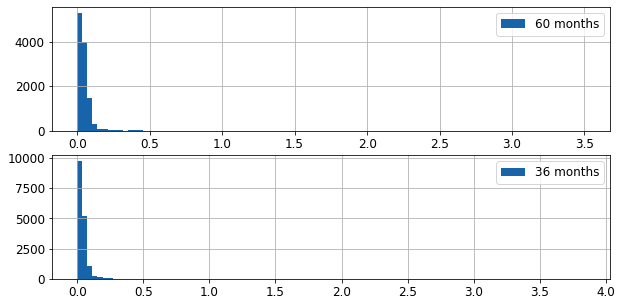

In [78]:
plt.subplot(211)
df_default_pos_60.hist(bins=100, label='60 months')
plt.legend()
#plt.xlim([0,0.2])
plt.subplot(212)
df_default_pos_36.hist(bins=100, label='36 months')
plt.legend()
#plt.xlim(0,0.2)

#### Bootstrapping Hypothesis Test


In [79]:
def Bootstrap_stat(data, size=2000):
    means= np.empty(size)
    for i in range(size):
       bootsample = np.random.choice(data, size=size)
       means[i] = np.mean(bootsample)
    return np.array(means)

calculate mean of postive return in good and bad loan

In [80]:
bs_payoff_pos = Bootstrap_stat(df_payoff_pos['Annual_ROI'], size=2000)
bs_default_pos = Bootstrap_stat(df_default_pos['Annual_ROI'], size=2000)

In [81]:
print(np.mean(bs_payoff_pos), np.std(bs_payoff_pos ))
print(np.mean(bs_default_pos), np.std(bs_default_pos ))

0.09375653479267029 0.001122178792962197
0.04290114675784017 0.0016710086392784935


In [82]:
bs_default_pos_60 = Bootstrap_stat(df_default_pos_60, 2000)
print(np.mean(bs_default_pos_60), np.std(bs_default_pos_60))
bs_default_pos_36 = Bootstrap_stat(df_default_pos_36, 2000)
print(np.mean(bs_default_pos_36), np.std(bs_default_pos_36))

0.04492354317198964 0.001395607382987428
0.04144671102413662 0.00173822864384427


<Figure size 720x360 with 0 Axes>

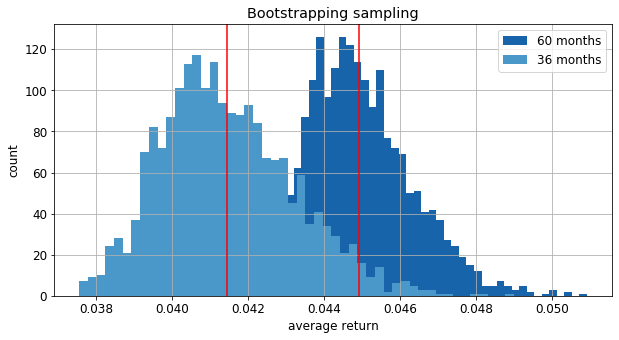

In [83]:
plt.figure(figsize=(10,5))
ax=pd.DataFrame(bs_default_pos_60).hist(bins=50, label='60 months')
pd.DataFrame(bs_default_pos_36).hist(bins=50, ax=ax, label='36 months')
plt.axvline(bs_default_pos_60.mean(), color='r')
plt.axvline(bs_default_pos_36.mean(), color='r')
plt.title('Bootstrapping sampling')
plt.legend()
plt.xlabel('average return')
plt.ylabel('count')
plt.show()

Hypothesis test
- H0: average return for 60 month and 36 month default loan are the same
- H1: average return for 60 month and 46 month default loan are different



In [84]:
# Compute mean of two data
data_concat = np.concatenate([bs_default_pos_36, bs_default_pos_60])
mean_data = np.mean(data_concat)

# Generate shifted arrays
df_default_pos_36s = df_default_pos_36 - np.mean(bs_default_pos_36) + mean_data
df_default_pos_60s = df_default_pos_60 - np.mean(bs_default_pos_60) + mean_data

# compute bootstrap replicates from the shifted arrays
bs_default_pos_36s = Bootstrap_stat(df_default_pos_36s, 10000)
bs_default_pos_60s = Bootstrap_stat(df_default_pos_60s, 10000)

# Get replicates of difference of means
bs_replicates = bs_default_pos_60s - bs_default_pos_36s

# Compute and print p-value: p
p = np.sum(bs_replicates <= (np.mean(df_default_pos_60s)-np.mean(df_default_pos_36s)) ) / 10000
print('p-value =', p)

p-value = 0.4927


p > 0.05. We can not reject H0, so the return for 36 month and 60 month loan are the same for the default loan.

## Income vs default 

Compare the default rate of borrowers with income below median income (low income) vs borrowers with income above median income (high income).

In [85]:
# median income for entire population
median_inc = df['annual_inc'].median()
# high income vs low income
inc_above = df[df['annual_inc'] > median_inc]['target']
inc_below = df[df['annual_inc'] <= median_inc]['target']

In [86]:
print('default rate for high income borrower =', round(sum(inc_above)/len(inc_above),2))
print('default rate for low income borrower =', round(sum(inc_below)/len(inc_below),2))

default rate for high income borrower = 0.18
default rate for low income borrower = 0.22


In [87]:
def two_sided_ztest(data1, data2, value):
    ztest ,pval = stests.ztest(x1=data1, x2=data2 , value=value, alternative='two-sided')
    print('p value =', pval)
    if pval<0.05:
        print("reject null hypothesis")
    else:
        print("accept null hypothesis")

Hypothesis test:
- Null Hypothesis: The default rates for low income borrower and high income borrower are the same
- Alternative Hypothesis: The default rate for low income borrower is higher than that of high income borrower

In [88]:
two_sided_ztest(inc_below, inc_above,0)

p value = 0.0
reject null hypothesis


- Null hypothesis is rejected
- **The borrowers with income below median income are more likely to default on a loan.**


## Purpose of loan vs interest rate

In [89]:
df_purpose = df[['purpose','target', 'int_rate']]#.value_counts(normalize=True)

In [90]:
df['purpose'].value_counts()

debt_consolidation    960269
credit_card           370990
home_improvement      109503
other                  98018
major_purchase         35340
medical                19488
small_business         17101
car                    16636
vacation               11565
moving                 11390
house                   9271
wedding                 1342
renewable_energy        1061
educational                2
Name: purpose, dtype: int64

In [91]:
# remove educational 
df_purpose = df_purpose[df_purpose['purpose'] != 'educational']

In [92]:
df_purpose_1 = pd.DataFrame(df_purpose.groupby('purpose')['target'].sum()/df_purpose.groupby('purpose')['target'].count())
df_purpose_1.rename(columns={'target':'default_rate'}, inplace=True)
df_purpose_1=df_purpose_1.sort_values(by='default_rate', ascending=False)

In [93]:
df_purpose_2 =pd.DataFrame(df_purpose.groupby('purpose')['int_rate'].mean())
df_purpose_2.rename(columns={'int_rate':'mean_int_rate'}, inplace=True)
df_purpose_3 =pd.DataFrame(df_purpose.groupby('purpose')['int_rate'].std())
df_purpose_3.rename(columns={'int_rate':'std_int_rate'}, inplace=True)

In [94]:
df_purpose_4 = pd.concat([df_purpose_1, df_purpose_2, df_purpose_3], axis=1, join='inner')
df_purpose_4

,default_rate,mean_int_rate,std_int_rate
purpose,,,
small_business,0.291036,15.927872,5.388915
house,0.229425,15.101172,5.814447
moving,0.227656,15.066790,4.994392
renewable_energy,0.215834,15.377672,5.092227
medical,0.209565,13.911528,4.848425
debt_consolidation,0.208480,13.596403,4.812768
other,0.204024,14.504734,5.104129
major_purchase,0.190549,12.830134,4.989824
vacation,0.183312,13.635814,4.582070


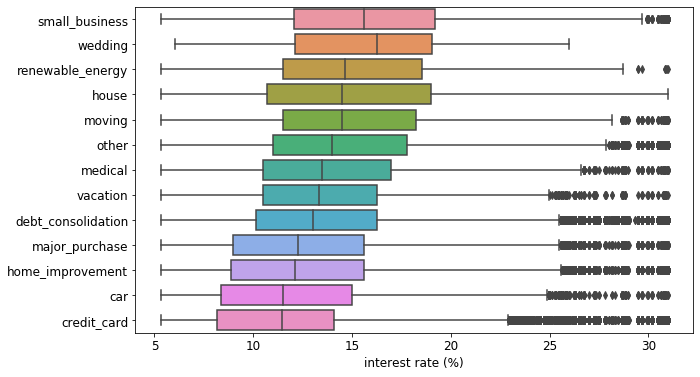

In [95]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
ranks = df_purpose_4['mean_int_rate'].sort_values(ascending=False).index
sns.boxplot(x='int_rate', y='purpose', data=df_purpose, order=ranks)
plt.xlabel('interest rate (%)')
plt.ylabel('')
plt.show()

The data has a very wide spread (large variation). 
perform ANOVA test to see if different purposes have different interest rate.

- Null Hypothesis: Different purposes have the same interest rate.
- Alternative Hypothesis: At least one purpose in the group has different interest rate.

In [96]:
list_purpose = df_purpose['purpose'].unique()
list_purpose

array(['other', 'debt_consolidation', 'home_improvement', 'credit_card',
       'major_purchase', 'small_business', 'house', 'moving', 'medical',
       'car', 'vacation', 'renewable_energy', 'wedding'], dtype=object)

In [97]:
df_purpose_new = pd.DataFrame()
for i, col in enumerate(list_purpose):
    df_purpose_new[col] = df_purpose[df_purpose['purpose']==str(col)]['int_rate'].reset_index(drop=True)

In [94]:
df_purpose_new.head()

,other,debt_consolidation,home_improvement,credit_card,major_purchase,small_business,house,moving,medical,car,vacation,renewable_energy,wedding
0,14.98,7.62,10.99,13.53,14.98,18.25,13.53,20.50,20.50,7.62,19.22,22.4,25.80
1,16.24,10.99,13.98,7.62,15.61,18.25,23.40,13.53,13.98,15.61,14.98,20.5,11.99
2,19.22,10.99,20.50,17.57,16.24,25.80,22.40,20.50,18.25,11.99,18.25,20.2,19.20
3,13.53,6.62,9.67,9.67,11.99,18.25,20.50,10.99,16.24,14.47,15.61,23.4,12.99
4,19.97,12.85,12.85,10.99,13.53,23.70,24.08,19.22,16.24,14.98,13.53,23.7,20.20


In [98]:
# compute one-way ANOVA P value   
from scipy import stats  

data = [df_purpose_new[col].dropna() for col in df_purpose_new]
      
f_val, p_val = stats.f_oneway(*data)
  
print("One-way ANOVA P =", p_val)  
  
#One-way ANOVA P = 0.381509481874  

One-way ANOVA P = 0.0


p value for ANOVA test is very small, so we can reject null hypothesis.

- different purpose can affect the interest rate. 

## Purpose of loan vs default
- Chi2 test

In [99]:
# make contingency table
con_table = pd.crosstab(df_purpose['target'], df_purpose['purpose'])/len(df_purpose)            
con_table["P(target)"] = con_table.sum(axis=1).rename("P(purpose)")
con_table.append(con_table.sum(axis=0).rename(f"P({df_purpose['purpose'].name})"))                  

purpose,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,P(target)
target,,,,,,,,,,,,,,
0,0.008531,0.185389,0.457331,0.054394,0.004299,0.017212,0.009268,0.005293,0.046944,0.000501,0.007295,0.005683,0.000701,0.80284
1,0.001479,0.037834,0.120457,0.011493,0.001280,0.004052,0.002457,0.001560,0.012033,0.000138,0.002995,0.001276,0.000106,0.19716
P(purpose),0.010010,0.223223,0.577788,0.065887,0.005578,0.021264,0.011726,0.006853,0.058977,0.000638,0.010290,0.006959,0.000807,1.00000


In [100]:
#con_table#.sum(axis=1)
n=len(df_purpose)  
statistic, p_value, _, exp = stats.chi2_contingency(con_table * n)
print('Chi2 statistic =', statistic)
print('p value=', p_value)

Chi2 statistic = 4376.101536166306
p value= 0.0


small p value means we can reject the null hypothesis. 
- It means different purpose affect default.